Proses Preprocessing Data,Clustering serta interpretasi Cluster.

Kita ingin melakukan segmentasi Pelanggan dengan tujuan untuk penawaran dan marketing yang lebih tepat sasaran.

Proses yang dilakukan:
- Drop kolom yang tidak dipakai untuk clustering (mengurangi curse of dimensionality)
- Pembuatan transformer kolom dan pipeline
- Evaluasi skor untuk mencari Cluster Optimal berdasarkan WCSS dan Silhoutte Score
- Melakukan clustering berdasarkan jumlah cluster optimal
- Dimensionality reduction untuk visualisasi cluster
- Interpretasi hasil cluster serta saran bisnis

In [118]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [119]:
df = pd.read_csv("data/clean.csv")
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),age_bin,income_bin,spender_bin,score_per_income,age_income
0,Male,19,15,39,Teen,Low Income,Low Spender,2.600000,285
1,Male,21,15,81,Teen,Low Income,High Spender,5.400000,315
2,Female,20,16,6,Teen,Low Income,Low Spender,0.375000,320
3,Female,23,16,77,Teen,Low Income,High Spender,4.812500,368
4,Female,31,17,40,Young Adult,Low Income,Low Spender,2.352941,527


In [120]:
cols_to_drop = ['age_bin', 'income_bin', 'spender_bin', 'score_per_income', 'age_income','Age','Gender']
df_dropped = df.drop(columns=cols_to_drop)


In [121]:
num_col = df_dropped.select_dtypes('number').columns.to_list()
categorical_col = df_dropped.select_dtypes(['object','category']).columns.to_list()

transformers = ColumnTransformer([
    ('num_col',StandardScaler(),num_col),
    ('categorical_col',OneHotEncoder(drop='first'),categorical_col)
])

# pipeline = Pipeline([
    
# ])

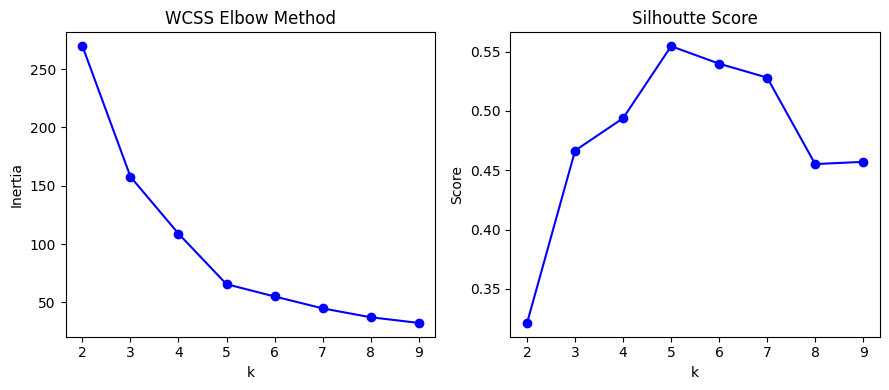

In [122]:
wcss = []
sil_score = []
k = range(2,10)
for i in k:
    pipeline = Pipeline([
        ('transformers',transformers),
        ('kmeans',KMeans(n_clusters=i,random_state=42,n_init=10))
        
    ])
    pipeline.fit(df_dropped)
    wcss.append(pipeline.named_steps['kmeans'].inertia_)
    labels = pipeline.named_steps['kmeans'].labels_
    X_transformed = pipeline.named_steps['transformers'].transform(df_dropped)
    sil_score.append(silhouette_score(X_transformed,labels))
    
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.title("WCSS Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.plot(k,wcss,'bo-')

plt.subplot(1,2,2)
plt.plot(k,sil_score,'bo-')
plt.xlabel("k")
plt.ylabel("Score")
plt.title("Silhoutte Score")

plt.tight_layout()
plt.show()


Berdasarkan Elbow Method dan juga Silhoutte Score, didapat jumlah Cluster optimal adalah 5

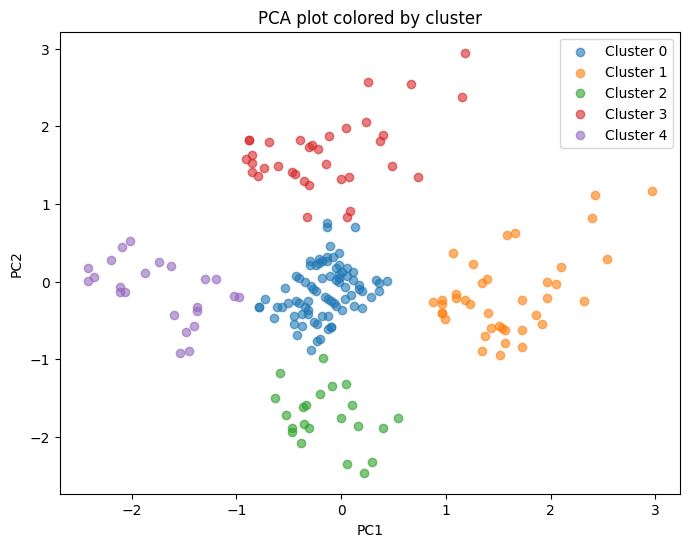

In [123]:
pipeline = Pipeline([
    ('transformers',transformers),
    ('kmeans',KMeans(n_clusters=5,random_state=42,n_init=10))
    
])
pipeline.fit(df_dropped)
X_transformed = pipeline.named_steps['transformers'].transform(df_dropped)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_transformed)

labels = pipeline.named_steps['kmeans'].labels_
unique_labels = np.unique(labels)
plt.figure(figsize=(8,6))
for label in unique_labels:
    idx = labels == label
    plt.scatter(pca_data[idx, 0], pca_data[idx, 1], label=f'Cluster {label}', alpha=0.6)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot colored by cluster')
plt.legend()
plt.show()

Setelah dilakukan plot, selanjutnya melakukan interpretasi dari Cluster yang sudah dibuat.

In [124]:
df['Cluster'] = labels
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),age_bin,income_bin,spender_bin,score_per_income,age_income,Cluster
0,Male,19,15,39,Teen,Low Income,Low Spender,2.600000,285,4
1,Male,21,15,81,Teen,Low Income,High Spender,5.400000,315,2
2,Female,20,16,6,Teen,Low Income,Low Spender,0.375000,320,4
3,Female,23,16,77,Teen,Low Income,High Spender,4.812500,368,2
4,Female,31,17,40,Young Adult,Low Income,Low Spender,2.352941,527,4


Melihat statistik deskriptif dari data berdasarkan Cluster

In [125]:
df.groupby('Cluster')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,81.0,42.716049,16.447822,18.0,27.00,46.0,54.00,70.0
1,39.0,32.692308,3.728650,27.0,30.00,32.0,35.50,40.0
2,22.0,25.272727,5.257030,18.0,21.25,23.5,29.75,35.0
3,35.0,41.114286,11.341676,19.0,34.00,42.0,47.50,59.0
4,23.0,45.217391,13.228607,19.0,35.50,46.0,53.50,67.0


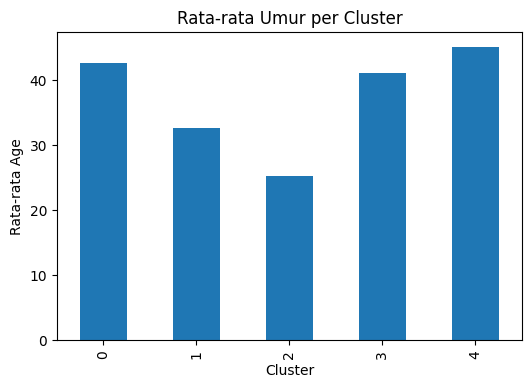

In [132]:
mean_age = df.groupby('Cluster')['Age'].mean()

mean_age.plot(kind='bar', figsize=(6,4))
plt.xlabel('Cluster')
plt.ylabel('Rata-rata Age')
plt.title('Rata-rata Umur per Cluster')
plt.show()

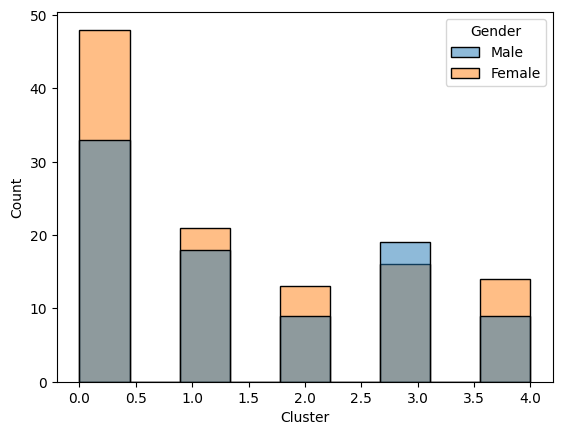

In [ ]:
sns.histplot(x = 'Cluster',data=df,hue='Gender')
plt.xlabel('Cluster')
plt.title("Cluster berdasarkan Gender")
plt.show()

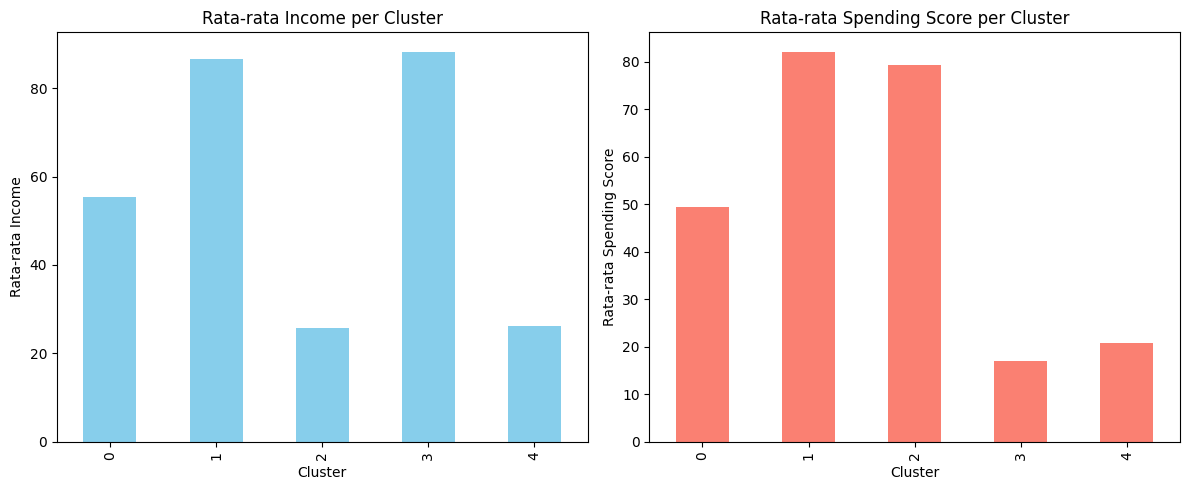

In [143]:
mean_income = df.groupby('Cluster')['Annual Income (k$)'].mean()
mean_spending = df.groupby('Cluster')['Spending Score (1-100)'].mean()

fig, axs = plt.subplots(1, 2, figsize=(12,5))

mean_income.plot(kind='bar', ax=axs[0], color='skyblue', title='Rata-rata Income per Cluster')
axs[0].set_xlabel('Cluster')
axs[0].set_ylabel('Rata-rata Income')

mean_spending.plot(kind='bar', ax=axs[1], color='salmon', title='Rata-rata Spending Score per Cluster')
axs[1].set_xlabel('Cluster')
axs[1].set_ylabel('Rata-rata Spending Score')

plt.tight_layout()
plt.show()

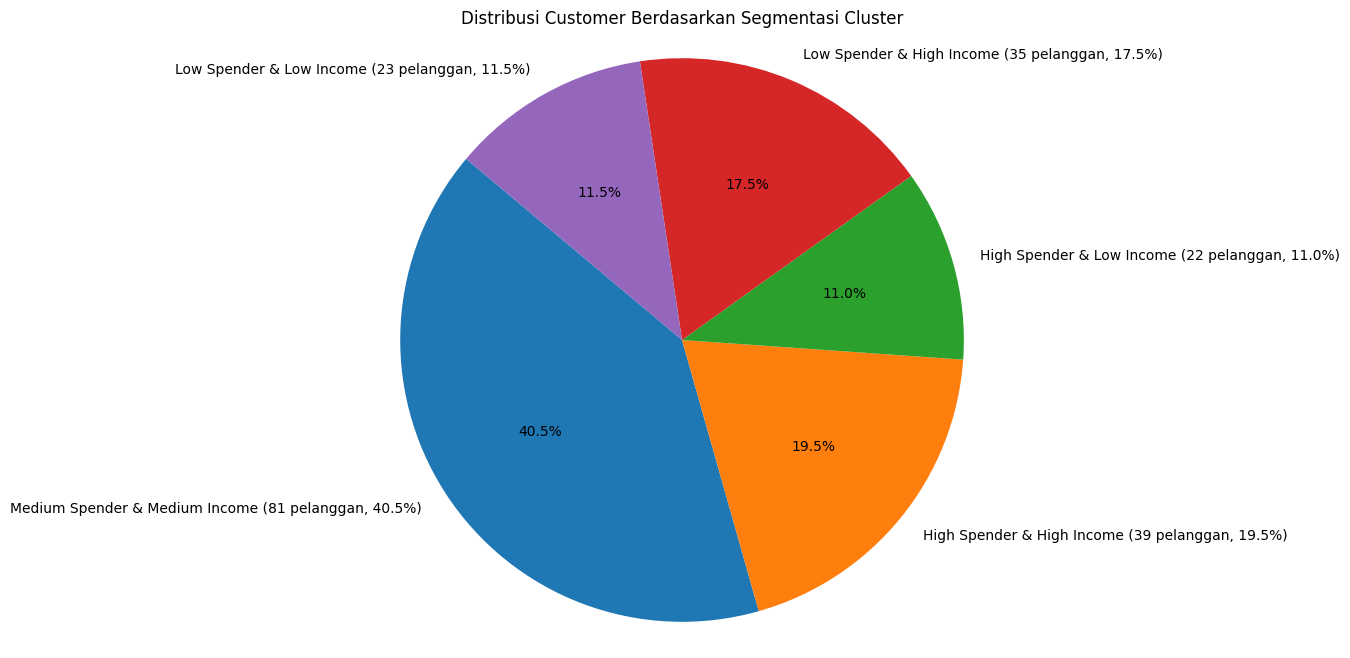

         count       mean        std   min    25%   50%    75%    max
Cluster                                                              
0         81.0  55.296296   8.988109  39.0  48.00  54.0  62.00   76.0
1         39.0  86.538462  16.312485  69.0  75.50  79.0  95.00  137.0
2         22.0  25.727273   7.566731  15.0  19.25  24.5  32.25   39.0
3         35.0  88.200000  16.399067  70.0  77.50  85.0  97.50  137.0
4         23.0  26.304348   7.893811  15.0  19.50  25.0  33.00   39.0
         count       mean        std   min   25%   50%    75%   max
Cluster                                                            
0         81.0  49.518519   6.530909  34.0  44.0  50.0  55.00  61.0
1         39.0  82.128205   9.364489  63.0  74.5  83.0  90.00  97.0
2         22.0  79.363636  10.504174  61.0  73.0  77.0  85.75  99.0
3         35.0  17.114286   9.952154   1.0  10.0  16.0  23.50  39.0
4         23.0  20.913043  13.017167   3.0   9.5  17.0  33.50  40.0


In [130]:
cluster_labels = {
    0: 'Medium Spender & Medium Income',
    1: 'High Spender & High Income',
    2: 'High Spender & Low Income',
    3: 'Low Spender & High Income',
    4: 'Low Spender & Low Income'
}

counts = df['Cluster'].value_counts().sort_index()

labels = [f"{cluster_labels[c]} ({counts[c]} pelanggan, {counts[c]/counts.sum()*100:.1f}%)" for c in counts.index]

plt.figure(figsize=(8,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Customer Berdasarkan Segmentasi Cluster')
plt.axis('equal')
plt.show()

print(df.groupby('Cluster')['Annual Income (k$)'].describe())
print(df.groupby('Cluster')['Spending Score (1-100)'].describe())

Berdasarkan rata-rata dan median Annual Income:

    - Cluster 1: Medium Income
    - Cluster 2: High Income
    - Cluster 3: Low Income
    - Cluster 4: High Income
    - Cluster 5: Low Income

Berdasarkan rata-rata dan median Spending Score:

    - Cluster 1: Medium Spender
    - Cluster 2: High Spender
    - Cluster 3: High Spender
    - Cluster 4: Low Spender
    - Cluster 5: Low Spender

Hasil akhir Segmentasi Customer yakni:

- Cluster 1: 
Medium Spender & Medium Income
Mereka pelanggan yang cukup sering belanja dan pendapatannya sedang-sedang aja.

Saran:
Berikan mereka alasan buat sering mampir, misalnya diskon khusus atau voucher kejutan. Bisa juga ajak mereka ikut program loyalitas yang bikin mereka merasa dihargai.


- Cluster 2: 
High Spender & High Income
Pelanggan ini suka belanja banyak dan punya dana yang memadai.

Saran:
Beri mereka pengalaman belanja yang spesial, seperti akses awal untuk promo atau produk baru. Jangan lupa layanan personal seperti personal shopper supaya mereka merasa istimewa.

- Cluster 3: 
High Spender & Low Income
Rata-rata yang memiliki umur muda, walau pendapatannya terbatas, mereka tetap sering belanja banyak—mungkin karena suka kredit atau cicilan.

Saran:
Tawarkan kemudahan pembayaran yang fleksibel, misal cicilan ringan tanpa bunga. Ingatkan juga produk-produk hemat tapi tetap keren dan berguna. Juga dengan tetap update dengan trend generasi muda karena cenderung impulsif dan permintaan tentang barang trending juga sangat besar.

- Cluster 4: 
Low Spender & High Income
Pelanggan kaya tapi jarang belanja. Bisa jadi mereka sibuk atau belum nemu produk favorit.

Saran:
Coba kenalkan mereka dengan promo menarik dan layanan yang bikin belanja jadi nyaman, seperti antar jemput atau layanan concierge. Kadang yang dibutuhkan cuma sedikit perhatian ekstra.

- Cluster 5: 
Low Spender & Low Income
Mereka mungkin cuma mampir sesekali dan belanja seadanya.

Saran:
Berikan mereka produk yang ramah di kantong dan promo yang gampang dimengerti. Event seru dan hiburan di mall juga bisa jadi alasan mereka datang lebih sering.